<img src="https://i.ibb.co/jGWqPCJ/banner.png">

# Predict Wind Speeds of Tropical Storms

__Team:__ ______ <br>
__Elements:__   Francisco Costa, João Gouveia, Pedro Rivera

<a class="anchor" id="Table_Contents"></a>
__Table of Contents:__ <br>
* [1. Business Understanding](#business-understanding)
* [2. Data Understanding](#data-understanding)
* [3. Data Preparation](#data-preparation)
* [4. Modeling](#modeling)
* [5. Conclusions](#conclusion)

<a class="anchor" id="business-understanding"></a>
## 1. Imports & Configs

In [2]:
#IMPORTS
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
%matplotlib inline

#SEABORN SETTINGS
sns.set_style('darkgrid')

#PANDAS SETTINGS
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
selected_device = '/GPU:0'

# with tf.device(selected_device_in):

In [4]:
# general definitions
batch_size = 256
img_width = 32
img_height = 32

In [5]:
training_dir = '../image_data/train'
test_dir = '../image_data/test'

<a class="anchor" id="data-understanding"></a>
## 2. Data Understanding

### 2.1 Features

In [6]:
train_features = pd.read_csv('data/training_set_features.csv')
train_features.head(8)

,image_id,storm_id,relative_time,ocean
0,abs_000,abs,0,2
1,abs_001,abs,1800,2
2,abs_002,abs,5400,2
3,abs_003,abs,17999,2
4,abs_004,abs,19799,2
5,abs_005,abs,32399,2
6,abs_006,abs,34199,2
7,abs_007,abs,37799,2


In [7]:
print('There are {} storms in this training dataset.'.format(train_features['storm_id'].nunique()))

There are 494 storms in this training dataset.


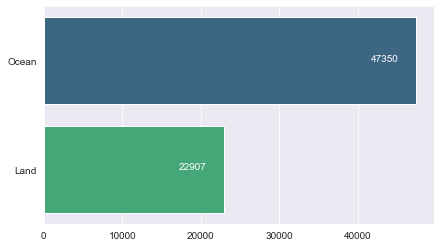

In [8]:
fig, ax = plt.subplots(figsize=(7,4))

ocean_values = train_features['ocean'].value_counts().values

sns.barplot(x=ocean_values,
            y=['Ocean', 'Land'],
            orient='h',
            palette='viridis',
            ax=ax)

for idx, val in enumerate(ocean_values):
    ax.text(x = val - ocean_values.min()*0.25,
            y = idx,
            s = val,
            **dict(size=10, color='white'))
    
plt.show()

### 2.2 Labels

In [9]:
train_labels = pd.read_csv('data/training_set_labels.csv')
train_labels.head()

,image_id,wind_speed
0,abs_000,43
1,abs_001,44
2,abs_002,45
3,abs_003,52
4,abs_004,53


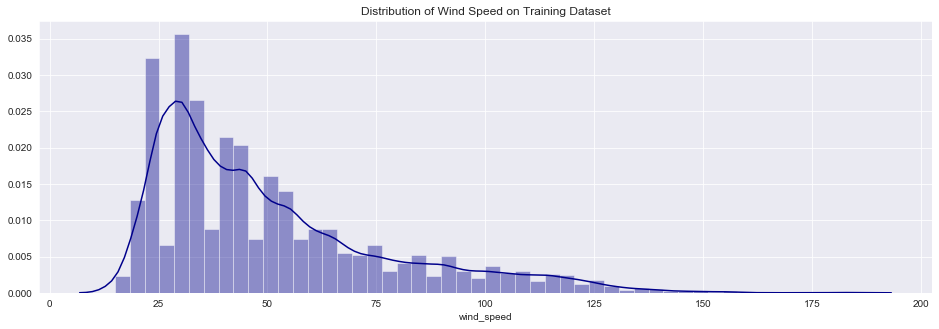

In [10]:
fig, ax = plt.subplots(figsize=(16,5))

plt.title('Distribution of Wind Speed on Training Dataset')
sns.distplot(a=train_labels['wind_speed'],color='darkblue')

plt.show()

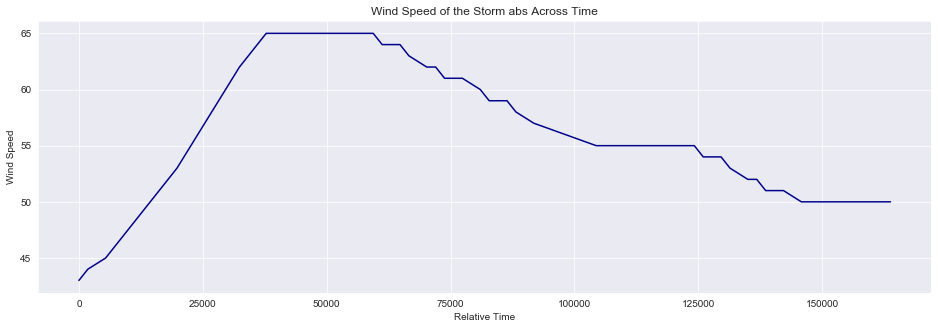

In [11]:
storm_choice = 'abs'

fig, ax = plt.subplots(figsize=(16,5))

time = train_features.loc[train_features['storm_id']==storm_choice]['relative_time'].values
speed = train_labels.loc[train_labels['image_id'].str.contains(storm_choice)]['wind_speed'].values

plt.title('Wind Speed of the Storm {} Across Time'.format(storm_choice))
plt.ylabel('Wind Speed')
plt.xlabel('Relative Time')
sns.lineplot(x=time, y=speed, color='darkblue')

plt.show()


### 2.3 Images

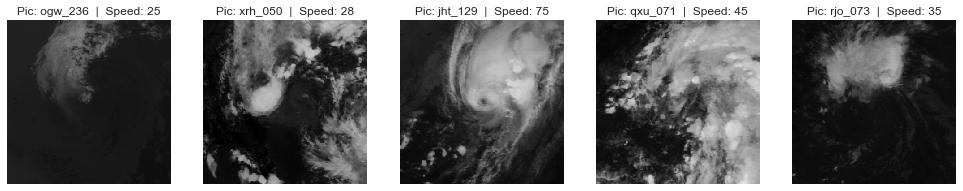

In [29]:
sample_images = []
train_imgs = [file for file in os.listdir(training_dir)]

for idx in np.random.randint(0,len(train_imgs),5):
    sample_images.append(training_dir+'/'+train_imgs[idx])

fig, axes = plt.subplots(1, 5, figsize=(17,8))

for idx,img in enumerate(sample_images):
    image = cv2.imread(img)
    name = img.split('/')[-1][:-4]
    wind_s = train_labels.loc[train_labels['image_id']==name]['wind_speed'].values[0]
    axes[idx].set_title('Pic: {}  |  Speed: {}'.format(name,wind_s))
    axes[idx].imshow(image)
    axes[idx].axis("off")

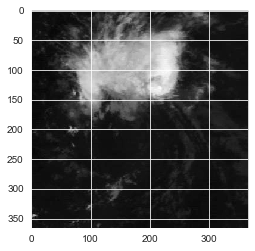

In [36]:
image2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image2, cmap='gray')

In [35]:
image2.shape

(366, 366)

In [14]:
for dim in range(0,image.shape[2]):
    print('Dimension {}: the maximum is {} and the minimum is {}.'.format(dim, image[dim].max(), image[dim].min()))

Dimension 0: the maximum is 108 and the minimum is 20.
Dimension 1: the maximum is 107 and the minimum is 20.
Dimension 2: the maximum is 107 and the minimum is 18.


In [15]:
storm_choice = 'rkw'

img_array = []
for file in os.listdir(training_dir):
    if storm_choice in file:
        img = cv2.imread(training_dir + '/' + file)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

out = cv2.VideoWriter('storm_example.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [16]:
cap = cv2.VideoCapture('storm_example.avi')

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        print("Stream ended")
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow('Storm {}'.format(storm_choice), gray)
    
    if cv2.waitKey(50) & 0xff==27:
        break
        
cap.release()
cv2.destroyAllWindows()

<a class="anchor" id="data-preparation"></a>
## 3. Data Preparation

In [17]:
images = [file for file in os.listdir('../image_test/raw')]

In [28]:
os.mkdir('../image_test/new')

for idx, img in enumerate(images):
    if idx != len(images)-1:
        cur_img = cv2.imread('../image_test/raw/' + images[idx])
        next_img = cv2.imread('../image_test/raw/' + images[idx+1])
        of_img = opticalFlowDense(cur_img, next_img)
        cv2.imwrite('../image_test/new/' + images[idx],
                    of_img)
    
    else:
        cur_img = cv2.imread('../image_test/raw/' + images[idx])
        of_img = opticalFlowDense(cur_img, cur_img)
        cv2.imwrite('../image_test/new/' + images[idx],
                    of_img)

In [24]:
def opticalFlowDense(image_current, image_next):
    
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    
    hsv = np.zeros((366, 366, 3))
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
#     flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow

In [22]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it

old_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

In [35]:
p0[1]

array([[364., 313.]], dtype=float32)

In [36]:
xs = [point[0][0] for point in p0]
ys = [point[0][1] for point in p0]

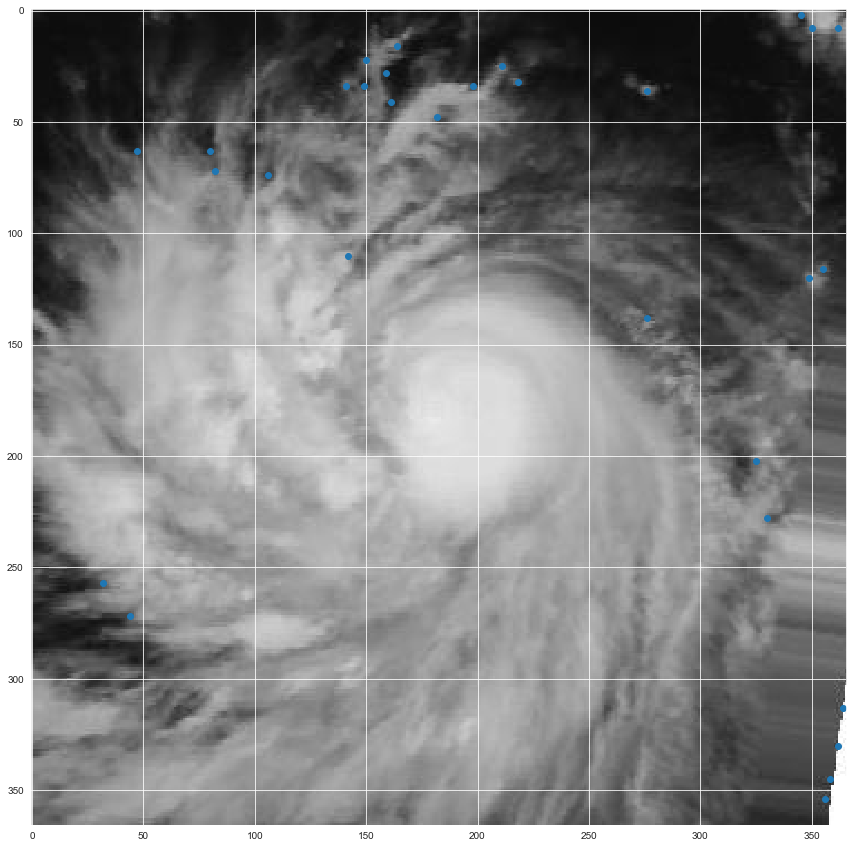

In [39]:
fig, ax = plt.subplots(figsize=(15,15))

plt.imshow(image)
plt.scatter(xs, ys, cmap='viridis')

In [51]:
image1 = plt.imread('../image_data/train/ojw_020.jpg')
#image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

image2 = plt.imread('../image_data/train/ojw_021.jpg')
#image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

(366, 366)

In [55]:
import cv2 as cv

In [58]:
cap = cv.VideoCapture("storm_example.avi")
ret, frame1 = cap.read()
prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255
while(1):
    ret, frame2 = cap.read()
    next = cv.cvtColor(frame2,cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)
    cv.imshow('frame2',bgr)
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv.imwrite('opticalfb.png',frame2)
        cv.imwrite('opticalhsv.png',bgr)
    prvs = next

error: OpenCV(3.4.2) c:\miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\imgproc\src\color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'cv::CvtHelper<struct cv::Set<3,4,-1>,struct cv::Set<1,-1,-1>,struct cv::Set<0,2,5>,2>::CvtHelper'


<a class="anchor" id="modeling"></a>
## 4. Modeling

<a class="anchor" id="conclusion"></a>
## 5. Conclusions